In [1]:
import torch
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import matthews_corrcoef
from torch.nn.functional import cross_entropy
from math import sqrt
import pickle

/home/daqop/anaconda3/envs/deeprank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_metrics(metrics_f):
    h5 = h5py.File(metrics_f)
    h5_keys = list(h5.keys())

    train_tpr = []
    train_losses = []
    train_tnr = []
    train_accuracies = []

    valid_tpr = []
    valid_losses = []
    valid_tnr = []
    valid_accuracies = []

    test_tpr = []
    test_losses = []
    test_tnr = []
    test_accuracies = []

    rocs = []
    aucs = []
    mccs = []

    for key in h5_keys:
        if "epoch_" in key:
            train_outputs = torch.tensor(h5[key]["train"]["outputs"], dtype=torch.float)
            valid_outputs = torch.tensor(h5[key]["valid"]["outputs"], dtype=torch.float)
            test_outputs = torch.tensor(h5[key]["test"]["outputs"], dtype=torch.float)

            train_labels = torch.tensor(h5[key]["train"]["targets"])
            valid_labels = torch.tensor(h5[key]["valid"]["targets"])
            test_labels = torch.tensor(h5[key]["test"]["targets"])

            
            train_tpr.append(h5[key]["train"]["tpr"][()])
            train_tnr.append(h5[key]["train"]["tnr"][()])
            train_accuracies.append(h5[key]["train"]["acc"][()])
            train_losses.append(cross_entropy(train_outputs, train_labels))

            valid_tpr.append(h5[key]["valid"]["tpr"][()])
            valid_tnr.append(h5[key]["valid"]["tnr"][()])
            valid_accuracies.append(h5[key]["valid"]["acc"][()])
            valid_losses.append(cross_entropy(valid_outputs, valid_labels))

            test_tpr.append(h5[key]["test"]["tpr"][()])
            test_tnr.append(h5[key]["test"]["tnr"][()])
            test_accuracies.append(h5[key]["test"]["acc"][()])
            test_losses.append(cross_entropy(test_outputs, test_labels))


            roc_tpr, roc_fpr, _ = roc_curve(test_labels, test_outputs.max(1)[0], pos_label=1.)
            rocs.append(torch.tensor([roc_fpr, roc_tpr]))
            aucs.append(auc(roc_fpr, roc_tpr))

            mccs.append(matthews_corrcoef(test_labels, test_outputs.max(1)[1]))

    return \
        aucs, mccs, \
        train_accuracies, valid_accuracies, test_accuracies,\
        train_tpr, valid_tpr, test_tpr,\
        train_tnr, valid_tnr, test_tnr,\
        train_losses, valid_losses, test_losses

In [3]:
models_path = "/home/daqop/Desktop/M2/Internship/python/trained_models"
metrics_files = glob.glob(f"{models_path}/cnn_3_conv_layers_clustered/*/metrics.hdf5")

all_aucs, all_mccs, \
all_train_accuracies, all_valid_accuracies, all_test_accuracies, \
all_train_tpr, all_valid_tpr, all_test_tpr, \
all_train_tnr, all_valid_tnr, all_test_tnr, \
all_train_losses, all_valid_losses, all_test_losses = [],[],[],[],[],[],[],[],[],[],[],[],[],[]

for metrics_file in metrics_files:
    aucs, mccs, \
    train_accuracy, valid_accuracy, test_accuracy, \
    train_tpr, valid_tpr, test_tpr, \
    train_tnr, valid_tnr, test_tnr, \
    train_losses, valid_losses, test_losses = get_metrics(metrics_file)

    all_aucs.append(aucs);all_mccs.append(mccs)
    all_train_accuracies.append(train_accuracy);all_valid_accuracies.append(valid_accuracy);all_test_accuracies.append(test_accuracy)
    all_train_tpr.append(train_tpr);all_valid_tpr.append(valid_tpr);all_test_tpr.append(test_tpr)
    all_train_tnr.append(train_tnr);all_valid_tnr.append(valid_tnr);all_test_tnr.append(test_tnr)
    all_train_losses.append(train_losses);all_valid_losses.append(valid_losses);all_test_losses.append(test_losses)

aucs = torch.tensor(all_aucs)
mccs = torch.tensor(all_mccs)

train_accuracies = torch.permute(torch.tensor(all_train_accuracies), (1,0))
valid_accuracies = torch.permute(torch.tensor(all_valid_accuracies), (1,0))
test_accuracies = torch.permute(torch.tensor(all_test_accuracies), (1,0))

train_tpr = torch.permute(torch.tensor(all_train_tpr), (1,0))
valid_tpr = torch.permute(torch.tensor(all_valid_tpr), (1,0))
test_tpr = torch.permute(torch.tensor(all_test_tpr), (1,0))

train_tnr = torch.permute(torch.tensor(all_train_tnr), (1,0))
valid_tnr = torch.permute(torch.tensor(all_valid_tnr), (1,0))
test_tnr = torch.permute(torch.tensor(all_test_tnr), (1,0))

train_losses = torch.permute(torch.tensor(all_train_losses), (1,0))
valid_losses = torch.permute(torch.tensor(all_valid_losses), (1,0))
test_losses = torch.permute(torch.tensor(all_test_losses), (1,0))

/tmp/ipykernel_41537/280269537.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  train_outputs = torch.tensor(h5[key]["train"]["outputs"], dtype=torch.float)


### METRICS FOR CLUSTERED CNN ### 
 

Mean AUC for 10 models: 0.6706026472156575
Mean MCC for 10 models: 0.6030887293014339
tensor(0.7983, dtype=torch.float64)


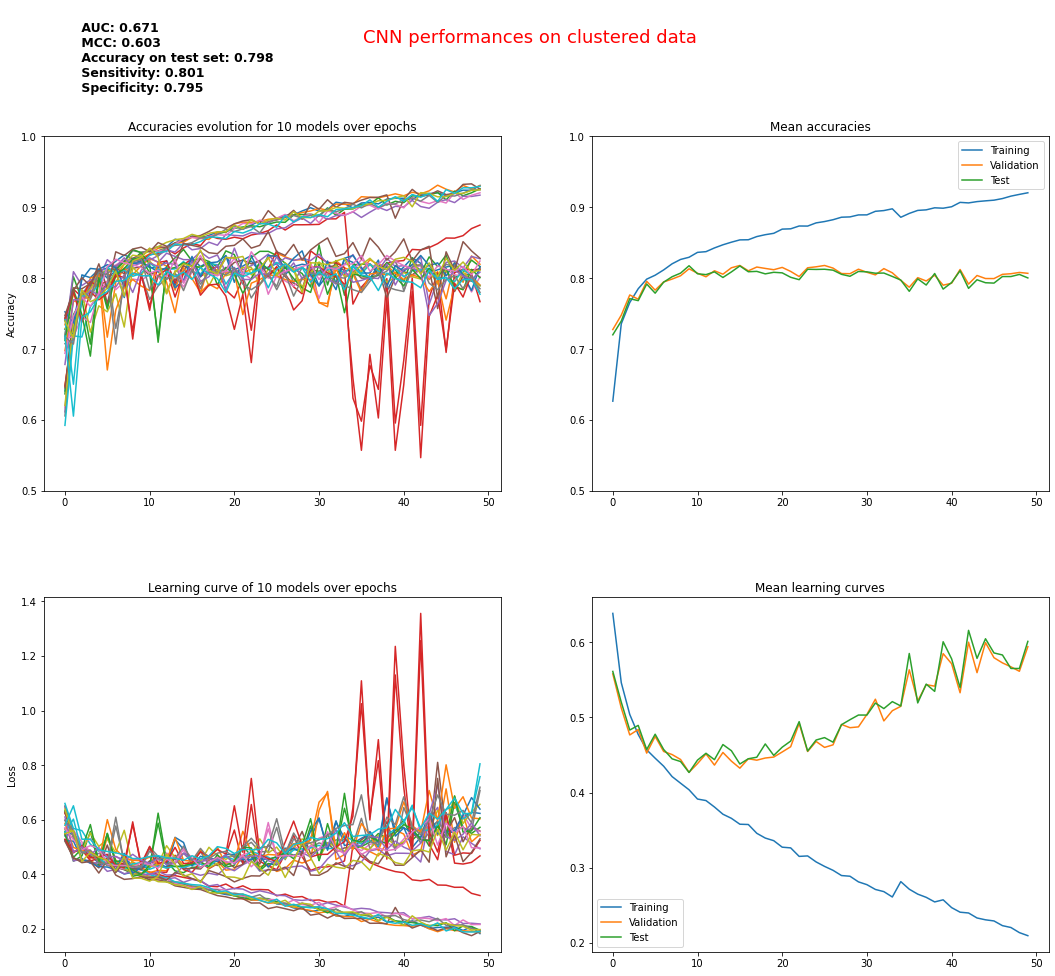

In [4]:
print("### METRICS FOR CLUSTERED CNN ### \n \n")
print(f"Mean AUC for 10 models: {aucs.nan_to_num().mean()}")
print(f"Mean MCC for 10 models: {mccs.nan_to_num().mean()}")

print(test_accuracies.mean())
fig = plt.figure(figsize=(18,15))
((ax1, ax2), (ax3, ax4)) = fig.subplots(2, 2)
fig.suptitle(f"CNN performances on clustered data", color="red", fontsize=18)
fig.text(
    0.15,1,
    f"\n AUC: {aucs.mean():.3} \n MCC: {mccs.mean():.3} \n \
Accuracy on test set: {test_accuracies.mean():.3} \n Sensitivity: {test_tpr.mean():.3} \n Specificity: {test_tnr.mean():.3}",
    horizontalalignment="left",
    verticalalignment="top",
    fontweight=700,
    fontsize=12.5
)

e = range(train_accuracies.shape[0])
ax1.plot(e, train_accuracies)
ax1.plot(e, valid_accuracies)
ax1.plot(e, test_accuracies)
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracies evolution for 10 models over epochs")
ax1.set_ylim(.5, 1)

ax2.plot(e, train_accuracies.mean(1))
ax2.plot(e, valid_accuracies.mean(1))
ax2.plot(e, test_accuracies.mean(1))
ax2.set_title("Mean accuracies")
ax2.legend(["Training", "Validation", "Test"])
ax2.set_ylim(.5, 1)

ax3.plot(e, train_losses)
ax3.plot(e, valid_losses)
ax3.plot(e, test_losses)
ax3.set_ylabel("Loss")
ax3.set_title("Learning curve of 10 models over epochs")

ax4.plot(e, train_losses.mean(1))
ax4.plot(e, valid_losses.mean(1))
ax4.plot(e, test_losses.mean(1))
ax4.set_title("Mean learning curves")
ax4.legend(["Training", "Validation", "Test"])

fig.subplots_adjust(
    wspace=.2,
    hspace=.3
)
# fig.savefig("./cnn_3_layers_batchnorm_dropout_clustere_results.png", transparent=False, facecolor="white")

f = open("./cnn_metrics_clustered.pkl", "wb")
obj = {
    "validation": {
        "accuracy": valid_accuracies,
    },
    "test": {
        "accuracy": test_accuracies,
    }
}
pickle.dump(obj, f)